In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(4, activation='relu'))
        
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 963195.4375 - mae: 694.1423 - mape: 45929.0977 - student_loss: 692.8226 - distillation_loss: 960022.6763 - val_mse: 199636.0000 - val_mae: 349.6117 - val_mape: 23795.1016 - val_student_loss: 242.7242
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 103995.0469 - mae: 238.7736 - mape: 15762.7646 - student_loss: 238.4357 - distillation_loss: 103709.7892 - val_mse: 42977.6445 - val_mae: 159.4268 - val_mape: 10822.7529 - val_student_loss: 108.2254
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 24871.9453 - mae: 114.9779 - mape: 7563.9883 - student_loss: 114.8758 - distillation_loss: 24821.1259 - val_mse: 10791.1924 - val_mae: 77.6938 - val_mape: 5251.0889 - val_student_loss: 50.6668
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 5885.7905 - mae: 53.3088 - mape: 3479.6794 - student_loss: 53.1669 - distillation_loss: 5867.5207 - val_m

443/443 [==============================] - 1s 3ms/step - mse: 1.0990 - mae: 0.8093 - mape: 54.3969 - student_loss: 0.8087 - distillation_loss: 0.6761 - val_mse: 0.9684 - val_mae: 0.7664 - val_mape: 54.0763 - val_student_loss: 0.9955
Epoch 34/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9440 - mae: 0.7541 - mape: 50.8007 - student_loss: 0.7542 - distillation_loss: 0.5235 - val_mse: 0.8558 - val_mae: 0.7334 - val_mape: 52.9001 - val_student_loss: 0.9280
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8401 - mae: 0.7110 - mape: 48.2939 - student_loss: 0.7101 - distillation_loss: 0.4304 - val_mse: 0.8165 - val_mae: 0.6922 - val_mape: 48.0848 - val_student_loss: 0.9214
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8195 - mae: 0.6963 - mape: 47.0984 - student_loss: 0.6954 - distillation_loss: 0.3918 - val_mse: 0.7574 - val_mae: 0.6676 - val_mape: 45.5933 - val_student_loss: 0.9077
Epoch 37/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.5339 - mae: 0.5568 - mape: 36.0007 - student_loss: 0.5576 - distillation_loss: 0.1264 - val_mse: 0.5053 - val_mae: 0.5325 - val_mape: 31.8038 - val_student_loss: 0.5690
Epoch 67/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5552 - mae: 0.5628 - mape: 36.3416 - student_loss: 0.5627 - distillation_loss: 0.1461 - val_mse: 0.4806 - val_mae: 0.5272 - val_mape: 33.2519 - val_student_loss: 0.5410
Epoch 68/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5519 - mae: 0.5628 - mape: 36.3779 - student_loss: 0.5624 - distillation_loss: 0.1405 - val_mse: 0.4866 - val_mae: 0.5475 - val_mape: 37.2563 - val_student_loss: 0.6042
Epoch 69/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5425 - mae: 0.5579 - mape: 36.0519 - student_loss: 0.5571 - distillation_loss: 0.1351 - val_mse: 0.4756 - val_mae: 0.5348 - val_mape: 35.2617 - val_student_loss: 0.5772
Epoch 70/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.4988 - mae: 0.5372 - mape: 34.3846 - student_loss: 0.5371 - distillation_loss: 0.0889 - val_mse: 0.5298 - val_mae: 0.5373 - val_mape: 30.4910 - val_student_loss: 0.5688
Epoch 100/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5082 - mae: 0.5421 - mape: 34.7822 - student_loss: 0.5418 - distillation_loss: 0.1032 - val_mse: 0.5202 - val_mae: 0.5342 - val_mape: 31.0114 - val_student_loss: 0.5693
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.7229 - mse: 3.9987 - mae: 1.7229 - mape: 86.1130 - val_loss: 1.4775 - val_mse: 3.1176 - val_mae: 1.4775 - val_mape: 70.0815
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2970 - mse: 2.6237 - mae: 1.2970 - mape: 58.5838 - val_loss: 1.1135 - val_mse: 2.0720 - val_mae: 1.1135 - val_mape: 49.5858
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0115 - mse: 1.8014 - mae: 1.0115 - mape: 

443/443 [==============================] - 1s 2ms/step - loss: 0.7703 - mse: 0.9900 - mae: 0.7703 - mape: 50.1600 - val_loss: 0.7636 - val_mse: 0.9645 - val_mae: 0.7636 - val_mape: 51.3629
Epoch 40/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7701 - mse: 0.9907 - mae: 0.7701 - mape: 50.0693 - val_loss: 0.7628 - val_mse: 0.9587 - val_mae: 0.7628 - val_mape: 51.7361
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7703 - mse: 0.9867 - mae: 0.7703 - mape: 50.4029 - val_loss: 0.7631 - val_mse: 0.9613 - val_mae: 0.7631 - val_mape: 51.5526
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7702 - mse: 0.9869 - mae: 0.7702 - mape: 50.3837 - val_loss: 0.7633 - val_mse: 0.9626 - val_mae: 0.7633 - val_mape: 51.4782
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7703 - mse: 0.9888 - mae: 0.7703 - mape: 50.2348 - val_loss: 0.7631 - val_mse: 0.9628 - val_mae: 0.7631 - val_mape: 51.4208
Epo

Epoch 80/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7701 - mse: 0.9882 - mae: 0.7701 - mape: 50.2473 - val_loss: 0.7632 - val_mse: 0.9610 - val_mae: 0.7632 - val_mape: 51.5773
Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7701 - mse: 0.9885 - mae: 0.7701 - mape: 50.2222 - val_loss: 0.7633 - val_mse: 0.9603 - val_mae: 0.7633 - val_mape: 51.6880
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7702 - mse: 0.9855 - mae: 0.7702 - mape: 50.4691 - val_loss: 0.7631 - val_mse: 0.9637 - val_mae: 0.7631 - val_mape: 51.3286
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7702 - mse: 0.9909 - mae: 0.7702 - mape: 50.0555 - val_loss: 0.7630 - val_mse: 0.9613 - val_mae: 0.7630 - val_mape: 51.5256
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7700 - mse: 0.9865 - mae: 0.7700 - mape: 50.3662 - val_loss: 0.7631 - val_mse: 0.9637 - val_mae: 0.7631 - val_mape

443/443 [==============================] - 1s 2ms/step - mse: 0.9500 - mae: 0.7807 - mape: 56.0253 - student_loss: 0.7796 - distillation_loss: 0.5115 - val_mse: 0.9649 - val_mae: 0.7890 - val_mape: 56.0627 - val_student_loss: 0.8047
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7813 - mape: 56.1646 - student_loss: 0.7797 - distillation_loss: 0.5113 - val_mse: 0.9644 - val_mae: 0.7880 - val_mape: 55.8525 - val_student_loss: 0.7999
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7811 - mape: 56.1191 - student_loss: 0.7809 - distillation_loss: 0.5119 - val_mse: 0.9652 - val_mae: 0.7876 - val_mape: 55.6993 - val_student_loss: 0.7948
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9500 - mae: 0.7812 - mape: 56.1740 - student_loss: 0.7808 - distillation_loss: 0.5131 - val_mse: 0.9653 - val_mae: 0.7866 - val_mape: 55.4513 - val_student_loss: 0.7884
Epoch 21/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9497 - mae: 0.7805 - mape: 56.0165 - student_loss: 0.7800 - distillation_loss: 0.5116 - val_mse: 0.9640 - val_mae: 0.7882 - val_mape: 55.9128 - val_student_loss: 0.8021
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9498 - mae: 0.7809 - mape: 56.0891 - student_loss: 0.7814 - distillation_loss: 0.5117 - val_mse: 0.9645 - val_mae: 0.7878 - val_mape: 55.8026 - val_student_loss: 0.7985
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9497 - mae: 0.7807 - mape: 56.0727 - student_loss: 0.7818 - distillation_loss: 0.5136 - val_mse: 0.9638 - val_mae: 0.7874 - val_mape: 55.7555 - val_student_loss: 0.7987
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9497 - mae: 0.7809 - mape: 56.1042 - student_loss: 0.7807 - distillation_loss: 0.5153 - val_mse: 0.9644 - val_mae: 0.7881 - val_mape: 55.8810 - val_student_loss: 0.8007
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9496 - mae: 0.7811 - mape: 56.1593 - student_loss: 0.7820 - distillation_loss: 0.5122 - val_mse: 0.9640 - val_mae: 0.7870 - val_mape: 55.6261 - val_student_loss: 0.7949
Epoch 84/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9498 - mae: 0.7805 - mape: 55.9790 - student_loss: 0.7804 - distillation_loss: 0.5116 - val_mse: 0.9636 - val_mae: 0.7883 - val_mape: 55.9827 - val_student_loss: 0.8048
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9497 - mae: 0.7811 - mape: 56.1431 - student_loss: 0.7813 - distillation_loss: 0.5134 - val_mse: 0.9641 - val_mae: 0.7876 - val_mape: 55.7813 - val_student_loss: 0.7987
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9496 - mae: 0.7811 - mape: 56.1730 - student_loss: 0.7799 - distillation_loss: 0.5119 - val_mse: 0.9641 - val_mae: 0.7868 - val_mape: 55.5802 - val_student_loss: 0.7938
Epoch 87/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7690 - mse: 0.9820 - mae: 0.7690 - mape: 50.6370 - val_loss: 0.7771 - val_mse: 1.0072 - val_mae: 0.7771 - val_mape: 50.0686
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9867 - mae: 0.7691 - mape: 50.2615 - val_loss: 0.7772 - val_mse: 1.0006 - val_mae: 0.7772 - val_mape: 50.5647
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9832 - mae: 0.7691 - mape: 50.5459 - val_loss: 0.7772 - val_mse: 1.0007 - val_mae: 0.7772 - val_mape: 50.5522
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9842 - mae: 0.7691 - mape: 50.4686 - val_loss: 0.7772 - val_mse: 1.0018 - val_mae: 0.7772 - val_mape: 50.4638
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9838 - mae: 0.7691 - mape: 50.5039 - val_loss: 0.7771 - val_mse: 1.0031 - val_mae: 0.7771 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7690 - mse: 0.9820 - mae: 0.7690 - mape: 50.6399 - val_loss: 0.7771 - val_mse: 1.0050 - val_mae: 0.7771 - val_mape: 50.2314
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7690 - mse: 0.9861 - mae: 0.7690 - mape: 50.3089 - val_loss: 0.7772 - val_mse: 0.9990 - val_mae: 0.7772 - val_mape: 50.6930
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9825 - mae: 0.7691 - mape: 50.6100 - val_loss: 0.7772 - val_mse: 1.0011 - val_mae: 0.7772 - val_mape: 50.5255
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9832 - mae: 0.7691 - mape: 50.5458 - val_loss: 0.7771 - val_mse: 1.0035 - val_mae: 0.7771 - val_mape: 50.3425
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7690 - mse: 0.9840 - mae: 0.7690 - mape: 50.4694 - val_loss: 0.7772 - val_mse: 1.0021 - val_mae: 0.7772 - val_mape: 50.4413
Epo

Fold 2
Epoch 1/100
443/443 [==============================] - 2s 3ms/step - mse: 3.9843 - mae: 1.7195 - mape: 86.1812 - student_loss: 1.7173 - distillation_loss: 3.5235 - val_mse: 3.3257 - val_mae: 1.5211 - val_mape: 72.6607 - val_student_loss: 1.1598
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2.7537 - mae: 1.3348 - mape: 60.7656 - student_loss: 1.3326 - distillation_loss: 2.2949 - val_mse: 2.3059 - val_mae: 1.1783 - val_mape: 52.4077 - val_student_loss: 0.8855
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.9292 - mae: 1.0529 - mape: 47.1790 - student_loss: 1.0532 - distillation_loss: 1.4814 - val_mse: 1.6698 - val_mae: 0.9639 - val_mape: 45.2599 - val_student_loss: 0.7350
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4364 - mae: 0.8873 - mape: 43.5882 - student_loss: 0.8867 - distillation_loss: 0.9866 - val_mse: 1.2962 - val_mae: 0.8507 - val_mape: 45.2713 - val_student_loss: 0.7350
Epoch 5/100
4

443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7807 - mape: 55.9787 - student_loss: 0.7807 - distillation_loss: 0.5118 - val_mse: 0.9622 - val_mae: 0.7931 - val_mape: 57.3689 - val_student_loss: 0.7350
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7804 - mape: 55.8922 - student_loss: 0.7815 - distillation_loss: 0.5121 - val_mse: 0.9622 - val_mae: 0.7930 - val_mape: 57.3649 - val_student_loss: 0.7350
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7803 - mape: 55.8399 - student_loss: 0.7802 - distillation_loss: 0.5115 - val_mse: 0.9621 - val_mae: 0.7932 - val_mape: 57.4105 - val_student_loss: 0.7350
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9508 - mae: 0.7797 - mape: 55.7199 - student_loss: 0.7820 - distillation_loss: 0.5168 - val_mse: 0.9618 - val_mae: 0.7955 - val_mape: 58.0172 - val_student_loss: 0.7350
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.9508 - mae: 0.7804 - mape: 55.8465 - student_loss: 0.7799 - distillation_loss: 0.5126 - val_mse: 0.9620 - val_mae: 0.7940 - val_mape: 57.6095 - val_student_loss: 0.7350
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9506 - mae: 0.7796 - mape: 55.6819 - student_loss: 0.7805 - distillation_loss: 0.5120 - val_mse: 0.9618 - val_mae: 0.7956 - val_mape: 58.0355 - val_student_loss: 0.7350
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7811 - mape: 56.0498 - student_loss: 0.7816 - distillation_loss: 0.5129 - val_mse: 0.9621 - val_mae: 0.7932 - val_mape: 57.4204 - val_student_loss: 0.7350
Epoch 70/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9506 - mae: 0.7803 - mape: 55.8534 - student_loss: 0.7810 - distillation_loss: 0.5121 - val_mse: 0.9621 - val_mae: 0.7933 - val_mape: 57.4225 - val_student_loss: 0.7350
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.9504 - mae: 0.7805 - mape: 55.9318 - student_loss: 0.7793 - distillation_loss: 0.5114 - val_mse: 0.9623 - val_mae: 0.7928 - val_mape: 57.2881 - val_student_loss: 0.7350
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4170 - mse: 13.5801 - mae: 1.4170 - mape: 100.1598 - val_loss: 1.2073 - val_mse: 2.6705 - val_mae: 1.2073 - val_mape: 99.2607
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0879 - mse: 7.4519 - mae: 1.0879 - mape: 74.7168 - val_loss: 1.0735 - val_mse: 2.3114 - val_mae: 1.0735 - val_mape: 57.3144
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9742 - mse: 4.2082 - mae: 0.9742 - mape: 65.6800 - val_loss: 0.7407 - val_mse: 1.2773 - val_mae: 0.7407 - val_mape: 47.7914
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8928 - mse: 2.2298 - mae: 0.8928 - mape: 59.0050 - val_loss: 1.1757 - val_mse: 2.3338

443/443 [==============================] - 1s 2ms/step - loss: 0.6514 - mse: 0.7999 - mae: 0.6514 - mape: 40.2730 - val_loss: 0.5408 - val_mse: 0.5563 - val_mae: 0.5408 - val_mape: 30.7765
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6765 - mse: 0.8518 - mae: 0.6765 - mape: 41.9651 - val_loss: 0.6795 - val_mse: 0.6976 - val_mae: 0.6795 - val_mape: 49.4247
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6630 - mse: 0.8303 - mae: 0.6630 - mape: 41.0485 - val_loss: 0.9878 - val_mse: 1.5510 - val_mae: 0.9878 - val_mape: 73.6029
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6299 - mse: 0.7527 - mae: 0.6299 - mape: 39.1007 - val_loss: 0.7011 - val_mse: 0.9001 - val_mae: 0.7011 - val_mape: 36.2955
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6759 - mse: 0.8489 - mae: 0.6759 - mape: 42.3320 - val_loss: 0.7319 - val_mse: 0.8191 - val_mae: 0.7319 - val_mape: 53.7101
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6728 - mse: 0.8759 - mae: 0.6728 - mape: 42.0672 - val_loss: 0.6090 - val_mse: 0.5823 - val_mae: 0.6090 - val_mape: 42.7508
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6794 - mse: 0.8401 - mae: 0.6794 - mape: 42.5394 - val_loss: 0.5197 - val_mse: 0.4817 - val_mae: 0.5197 - val_mape: 32.5790
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6409 - mse: 0.7728 - mae: 0.6409 - mape: 39.5340 - val_loss: 0.5061 - val_mse: 0.4783 - val_mae: 0.5061 - val_mape: 30.5707
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6252 - mse: 0.7225 - mae: 0.6252 - mape: 38.6908 - val_loss: 0.5082 - val_mse: 0.4924 - val_mae: 0.5082 - val_mape: 29.8607
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6482 - mse: 0.7562 - mae: 0.6482 - mape: 40.1573 - val_loss: 0.5104 - val_mse: 0.4738 - val_mae: 0.5104 - val_mape

443/443 [==============================] - 1s 3ms/step - mse: 1.5691 - mae: 0.9339 - mape: 43.7065 - student_loss: 0.9326 - distillation_loss: 1.1132 - val_mse: 1.4079 - val_mae: 0.8740 - val_mape: 43.3744 - val_student_loss: 0.3438
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4293 - mae: 0.8883 - mape: 43.3612 - student_loss: 0.8885 - distillation_loss: 0.9740 - val_mse: 1.2809 - val_mae: 0.8324 - val_mape: 43.4671 - val_student_loss: 0.2945
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3002 - mae: 0.8468 - mape: 43.5453 - student_loss: 0.8476 - distillation_loss: 0.8480 - val_mse: 1.1684 - val_mae: 0.7962 - val_mape: 44.1435 - val_student_loss: 0.2550
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1883 - mae: 0.8138 - mape: 44.4629 - student_loss: 0.8119 - distillation_loss: 0.7357 - val_mse: 1.0770 - val_mae: 0.7704 - val_mape: 45.5825 - val_student_loss: 0.2550
Epoch 21/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9543 - mae: 0.7825 - mape: 55.8258 - student_loss: 0.7823 - distillation_loss: 0.5148 - val_mse: 0.9290 - val_mae: 0.7742 - val_mape: 57.9207 - val_student_loss: 0.5631
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9540 - mae: 0.7833 - mape: 56.0238 - student_loss: 0.7840 - distillation_loss: 0.5149 - val_mse: 0.9287 - val_mae: 0.7729 - val_mape: 57.6624 - val_student_loss: 0.5567
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9542 - mae: 0.7825 - mape: 55.8074 - student_loss: 0.7828 - distillation_loss: 0.5160 - val_mse: 0.9291 - val_mae: 0.7743 - val_mape: 57.9534 - val_student_loss: 0.5639
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9543 - mae: 0.7823 - mape: 55.7762 - student_loss: 0.7815 - distillation_loss: 0.5154 - val_mse: 0.9297 - val_mae: 0.7762 - val_mape: 58.3312 - val_student_loss: 0.5731
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9543 - mae: 0.7819 - mape: 55.6754 - student_loss: 0.7814 - distillation_loss: 0.5149 - val_mse: 0.9293 - val_mae: 0.7752 - val_mape: 58.1233 - val_student_loss: 0.5681
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9541 - mae: 0.7831 - mape: 55.9894 - student_loss: 0.7855 - distillation_loss: 0.5181 - val_mse: 0.9289 - val_mae: 0.7736 - val_mape: 57.7992 - val_student_loss: 0.5601
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9541 - mae: 0.7830 - mape: 55.9487 - student_loss: 0.7829 - distillation_loss: 0.5160 - val_mse: 0.9289 - val_mae: 0.7737 - val_mape: 57.8256 - val_student_loss: 0.5607
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9542 - mae: 0.7824 - mape: 55.8126 - student_loss: 0.7815 - distillation_loss: 0.5145 - val_mse: 0.9292 - val_mae: 0.7747 - val_mape: 58.0217 - val_student_loss: 0.5656
Epoch 87/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5499 - mse: 0.5824 - mae: 0.5499 - mape: 33.1312 - val_loss: 0.7709 - val_mse: 0.9305 - val_mae: 0.7709 - val_mape: 57.7887
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5456 - mse: 0.5599 - mae: 0.5456 - mape: 32.8331 - val_loss: 0.5613 - val_mse: 0.5376 - val_mae: 0.5613 - val_mape: 37.2412
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5450 - mse: 0.5714 - mae: 0.5450 - mape: 32.6874 - val_loss: 0.5831 - val_mse: 0.6540 - val_mae: 0.5831 - val_mape: 32.0287
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5424 - mse: 0.5565 - mae: 0.5424 - mape: 32.7572 - val_loss: 0.5353 - val_mse: 0.5464 - val_mae: 0.5353 - val_mape: 31.9039
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5497 - mse: 0.5797 - mae: 0.5497 - mape: 33.1878 - val_loss: 0.5708 - val_mse: 0.6308 - val_mae: 0.5708 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5086 - mse: 0.4682 - mae: 0.5086 - mape: 30.6857 - val_loss: 0.4975 - val_mse: 0.4518 - val_mae: 0.4975 - val_mape: 31.9590
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4969 - mse: 0.4477 - mae: 0.4969 - mape: 30.0413 - val_loss: 0.5210 - val_mse: 0.4732 - val_mae: 0.5210 - val_mape: 34.9345
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4997 - mse: 0.4553 - mae: 0.4997 - mape: 30.1493 - val_loss: 0.5214 - val_mse: 0.4712 - val_mae: 0.5214 - val_mape: 35.2266
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5006 - mse: 0.4569 - mae: 0.5006 - mape: 30.2511 - val_loss: 0.5375 - val_mse: 0.4960 - val_mae: 0.5375 - val_mape: 36.4553
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5002 - mse: 0.4544 - mae: 0.5002 - mape: 30.2121 - val_loss: 0.4978 - val_mse: 0.4612 - val_mae: 0.4978 - val_mape: 30.7496
Epo

Fold 4
Epoch 1/100
443/443 [==============================] - 1s 3ms/step - mse: 3.9719 - mae: 1.7161 - mape: 85.5324 - student_loss: 1.7125 - distillation_loss: 3.5082 - val_mse: 3.2889 - val_mae: 1.5320 - val_mape: 71.5883 - val_student_loss: 1.1427
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2.7610 - mae: 1.3306 - mape: 60.2921 - student_loss: 1.3317 - distillation_loss: 2.3082 - val_mse: 2.2942 - val_mae: 1.1929 - val_mape: 52.0873 - val_student_loss: 0.8779
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.9546 - mae: 1.0509 - mape: 46.9093 - student_loss: 1.0537 - distillation_loss: 1.5129 - val_mse: 1.6574 - val_mae: 0.9752 - val_mape: 44.8168 - val_student_loss: 0.7193
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4569 - mae: 0.8869 - mape: 43.4769 - student_loss: 0.8846 - distillation_loss: 1.0087 - val_mse: 1.2814 - val_mae: 0.8506 - val_mape: 44.0824 - val_student_loss: 0.5938
Epoch 5/100
4

443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7820 - mape: 56.0896 - student_loss: 0.7817 - distillation_loss: 0.5147 - val_mse: 0.9444 - val_mae: 0.7769 - val_mape: 55.0763 - val_student_loss: 0.6118
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7821 - mape: 56.1152 - student_loss: 0.7816 - distillation_loss: 0.5168 - val_mse: 0.9444 - val_mae: 0.7768 - val_mape: 55.0595 - val_student_loss: 0.6116
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7813 - mape: 55.9251 - student_loss: 0.7808 - distillation_loss: 0.5161 - val_mse: 0.9436 - val_mae: 0.7782 - val_mape: 55.4870 - val_student_loss: 0.6178
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7822 - mape: 56.1494 - student_loss: 0.7827 - distillation_loss: 0.5143 - val_mse: 0.9439 - val_mae: 0.7776 - val_mape: 55.3050 - val_student_loss: 0.6152
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9524 - mae: 0.7821 - mape: 56.1163 - student_loss: 0.7823 - distillation_loss: 0.5142 - val_mse: 0.9444 - val_mae: 0.7769 - val_mape: 55.0796 - val_student_loss: 0.6119
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7821 - mape: 56.1305 - student_loss: 0.7806 - distillation_loss: 0.5152 - val_mse: 0.9443 - val_mae: 0.7770 - val_mape: 55.1080 - val_student_loss: 0.6123
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7815 - mape: 55.9607 - student_loss: 0.7797 - distillation_loss: 0.5141 - val_mse: 0.9437 - val_mae: 0.7779 - val_mape: 55.3986 - val_student_loss: 0.6165
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7821 - mape: 56.1243 - student_loss: 0.7832 - distillation_loss: 0.5142 - val_mse: 0.9438 - val_mae: 0.7778 - val_mape: 55.3615 - val_student_loss: 0.6160
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7818 - mape: 56.0441 - student_loss: 0.7830 - distillation_loss: 0.5159 - val_mse: 0.9438 - val_mae: 0.7778 - val_mape: 55.3570 - val_student_loss: 0.6159
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 2.3142 - mse: 28.8325 - mae: 2.3142 - mape: 128.5330 - val_loss: 0.8596 - val_mse: 1.3579 - val_mae: 0.8596 - val_mape: 45.6406
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7842 - mse: 1.1248 - mae: 0.7842 - mape: 48.8496 - val_loss: 0.7782 - val_mse: 1.0233 - val_mae: 0.7782 - val_mape: 50.3927
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7735 - mse: 1.0342 - mae: 0.7735 - mape: 50.6376 - val_loss: 0.7753 - val_mse: 1.0079 - val_mae: 0.7753 - val_mape: 49.7722
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7723 - mse: 1.0120 - mae: 0.7723 - mape: 50.4971 - val_loss: 0.7751 - val_mse: 1.0086

443/443 [==============================] - 1s 2ms/step - loss: 0.7698 - mse: 0.9886 - mae: 0.7698 - mape: 50.3126 - val_loss: 0.7723 - val_mse: 0.9811 - val_mae: 0.7723 - val_mape: 50.6697
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9871 - mae: 0.7697 - mape: 50.4411 - val_loss: 0.7731 - val_mse: 0.9920 - val_mae: 0.7731 - val_mape: 49.8652
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7698 - mse: 0.9891 - mae: 0.7698 - mape: 50.2829 - val_loss: 0.7730 - val_mse: 0.9913 - val_mae: 0.7730 - val_mape: 49.8741
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9891 - mae: 0.7697 - mape: 50.2783 - val_loss: 0.7737 - val_mse: 0.9959 - val_mae: 0.7737 - val_mape: 49.7080
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7695 - mse: 0.9879 - mae: 0.7695 - mape: 50.2860 - val_loss: 0.7723 - val_mse: 0.9797 - val_mae: 0.7723 - val_mape: 50.7748
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9904 - mae: 0.7697 - mape: 50.1441 - val_loss: 0.7727 - val_mse: 0.9852 - val_mae: 0.7727 - val_mape: 50.4350
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9878 - mae: 0.7696 - mape: 50.3317 - val_loss: 0.7722 - val_mse: 0.9826 - val_mae: 0.7722 - val_mape: 50.5122
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9878 - mae: 0.7697 - mape: 50.3651 - val_loss: 0.7730 - val_mse: 0.9891 - val_mae: 0.7730 - val_mape: 50.1506
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9886 - mae: 0.7696 - mape: 50.2993 - val_loss: 0.7739 - val_mse: 0.9986 - val_mae: 0.7739 - val_mape: 49.5127
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9896 - mae: 0.7696 - mape: 50.2059 - val_loss: 0.7724 - val_mse: 0.9812 - val_mae: 0.7724 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7745 - mae: 0.6661 - mape: 43.7208 - student_loss: 0.6675 - distillation_loss: 0.3430 - val_mse: 0.7750 - val_mae: 0.6331 - val_mape: 36.5265 - val_student_loss: 1.1027
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9433 - mae: 0.7150 - mape: 47.0152 - student_loss: 0.7145 - distillation_loss: 0.5056 - val_mse: 0.7316 - val_mae: 0.6209 - val_mape: 36.4324 - val_student_loss: 0.9414
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1693 - mae: 0.7653 - mape: 50.1207 - student_loss: 0.7652 - distillation_loss: 0.7208 - val_mse: 1.4712 - val_mae: 0.9013 - val_mape: 49.0347 - val_student_loss: 1.4549
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1117 - mae: 0.7769 - mape: 50.6664 - student_loss: 0.7778 - distillation_loss: 0.6891 - val_mse: 3.4066 - val_mae: 1.4464 - val_mape: 106.8776 - val_student_loss: 1.2772
Epoch 22/100
44

443/443 [==============================] - 1s 2ms/step - mse: 1.1768 - mae: 0.7489 - mape: 49.1617 - student_loss: 0.7476 - distillation_loss: 0.7653 - val_mse: 1.2440 - val_mae: 0.8154 - val_mape: 41.7183 - val_student_loss: 1.3676
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3419 - mae: 0.8266 - mape: 54.2322 - student_loss: 0.8259 - distillation_loss: 0.9100 - val_mse: 0.6169 - val_mae: 0.5857 - val_mape: 39.6655 - val_student_loss: 0.8011
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 2.4995 - mae: 0.9938 - mape: 66.1186 - student_loss: 0.9914 - distillation_loss: 2.0728 - val_mse: 0.5221 - val_mae: 0.5409 - val_mape: 34.6167 - val_student_loss: 0.7946
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 1.7706 - mae: 0.9067 - mape: 59.6220 - student_loss: 0.9044 - distillation_loss: 1.3487 - val_mse: 1.3494 - val_mae: 0.8388 - val_mape: 49.1174 - val_student_loss: 1.2235
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.7883 - mae: 0.6517 - mape: 42.3007 - student_loss: 0.6528 - distillation_loss: 0.3668 - val_mse: 0.6758 - val_mae: 0.5560 - val_mape: 32.5841 - val_student_loss: 0.7120
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3469 - mae: 0.7679 - mape: 49.7573 - student_loss: 0.7702 - distillation_loss: 0.9669 - val_mse: 1.7379 - val_mae: 1.0380 - val_mape: 54.7971 - val_student_loss: 1.5505
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1238 - mae: 0.7178 - mape: 46.3547 - student_loss: 0.7175 - distillation_loss: 0.7085 - val_mse: 0.5169 - val_mae: 0.5320 - val_mape: 32.7572 - val_student_loss: 0.7472
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8731 - mae: 0.6640 - mape: 43.0183 - student_loss: 0.6631 - distillation_loss: 0.4777 - val_mse: 0.5215 - val_mae: 0.5356 - val_mape: 35.6512 - val_student_loss: 0.6655
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9816 - mae: 0.7699 - mape: 50.6589 - val_loss: 0.7688 - val_mse: 1.0037 - val_mae: 0.7688 - val_mape: 50.1674
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7700 - mse: 0.9839 - mae: 0.7700 - mape: 50.4853 - val_loss: 0.7690 - val_mse: 1.0011 - val_mae: 0.7690 - val_mape: 50.3678
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9823 - mae: 0.7699 - mape: 50.5979 - val_loss: 0.7690 - val_mse: 1.0010 - val_mae: 0.7690 - val_mape: 50.3788
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9824 - mae: 0.7699 - mape: 50.6000 - val_loss: 0.7691 - val_mse: 1.0000 - val_mae: 0.7691 - val_mape: 50.4566
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9838 - mae: 0.7699 - mape: 50.4844 - val_loss: 0.7692 - val_mse: 0.9988 - val_mae: 0.7692 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9806 - mae: 0.7699 - mape: 50.7362 - val_loss: 0.7688 - val_mse: 1.0039 - val_mae: 0.7688 - val_mape: 50.1507
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9855 - mae: 0.7699 - mape: 50.3563 - val_loss: 0.7692 - val_mse: 0.9987 - val_mae: 0.7692 - val_mape: 50.5639
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9830 - mae: 0.7699 - mape: 50.5474 - val_loss: 0.7690 - val_mse: 1.0012 - val_mae: 0.7690 - val_mape: 50.3617
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9821 - mae: 0.7699 - mape: 50.6283 - val_loss: 0.7689 - val_mse: 1.0029 - val_mae: 0.7689 - val_mape: 50.2286
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9845 - mae: 0.7699 - mape: 50.4272 - val_loss: 0.7690 - val_mse: 1.0006 - val_mae: 0.7690 - val_mape: 50.4081
Epo

443/443 [==============================] - 1s 3ms/step - mse: 101373.4766 - mae: 234.8845 - mape: 15614.1943 - student_loss: 234.4029 - distillation_loss: 101041.8307 - val_mse: 31215.8906 - val_mae: 137.9277 - val_mape: 8891.6113 - val_student_loss: 176.6649
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 12372.6270 - mae: 70.4761 - mape: 4668.1621 - student_loss: 70.1930 - distillation_loss: 12326.9476 - val_mse: 3.0005 - val_mae: 1.4539 - val_mape: 68.0588 - val_student_loss: 2.1604
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 3.0571 - mae: 1.4493 - mape: 67.2649 - student_loss: 1.4481 - distillation_loss: 2.5956 - val_mse: 2.9865 - val_mae: 1.4491 - val_mape: 67.7445 - val_student_loss: 2.1556
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 3.0380 - mae: 1.4433 - mape: 66.8725 - student_loss: 1.4431 - distillation_loss: 2.5836 - val_mse: 2.9677 - val_mae: 1.4426 - val_mape: 67.3211 - val_student_loss: 

443/443 [==============================] - 1s 2ms/step - mse: 0.9588 - mae: 0.7845 - mape: 56.2999 - student_loss: 0.7854 - distillation_loss: 0.5176 - val_mse: 0.8882 - val_mae: 0.7504 - val_mape: 52.2713 - val_student_loss: 0.7221
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9587 - mae: 0.7852 - mape: 56.4803 - student_loss: 0.7861 - distillation_loss: 0.5147 - val_mse: 0.8882 - val_mae: 0.7506 - val_mape: 52.3135 - val_student_loss: 0.7209
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9587 - mae: 0.7851 - mape: 56.4437 - student_loss: 0.7846 - distillation_loss: 0.5144 - val_mse: 0.8881 - val_mae: 0.7512 - val_mape: 52.4605 - val_student_loss: 0.7167
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9585 - mae: 0.7855 - mape: 56.5692 - student_loss: 0.7839 - distillation_loss: 0.5141 - val_mse: 0.8886 - val_mae: 0.7489 - val_mape: 51.8890 - val_student_loss: 0.7332
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9586 - mae: 0.7852 - mape: 56.4748 - student_loss: 0.7865 - distillation_loss: 0.5164 - val_mse: 0.8885 - val_mae: 0.7492 - val_mape: 51.9711 - val_student_loss: 0.7308
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9589 - mae: 0.7847 - mape: 56.3207 - student_loss: 0.7848 - distillation_loss: 0.5160 - val_mse: 0.8882 - val_mae: 0.7502 - val_mape: 52.2338 - val_student_loss: 0.7232
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9587 - mae: 0.7854 - mape: 56.5350 - student_loss: 0.7856 - distillation_loss: 0.5154 - val_mse: 0.8882 - val_mae: 0.7504 - val_mape: 52.2751 - val_student_loss: 0.7220
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9588 - mae: 0.7852 - mape: 56.4746 - student_loss: 0.7850 - distillation_loss: 0.5145 - val_mse: 0.8884 - val_mae: 0.7495 - val_mape: 52.0449 - val_student_loss: 0.7287
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9588 - mae: 0.7849 - mape: 56.4095 - student_loss: 0.7860 - distillation_loss: 0.5172 - val_mse: 0.8883 - val_mae: 0.7497 - val_mape: 52.1127 - val_student_loss: 0.7267
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6140 - mse: 11.5587 - mae: 1.6140 - mape: 101.6336 - val_loss: 0.9578 - val_mse: 1.6587 - val_mae: 0.9578 - val_mape: 50.4565
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9479 - mse: 2.2546 - mae: 0.9479 - mape: 54.8879 - val_loss: 0.8373 - val_mse: 1.2238 - val_mae: 0.8373 - val_mape: 46.8707
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8566 - mse: 1.7214 - mae: 0.8566 - mape: 51.8473 - val_loss: 0.7793 - val_mse: 1.0597 - val_mae: 0.7793 - val_mape: 44.5081
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8178 - mse: 1.3561 - mae: 0.8178 - mape: 50.7399 - val_loss: 0.7485 - val_mse: 0.9452

443/443 [==============================] - 1s 2ms/step - loss: 0.5068 - mse: 0.4721 - mae: 0.5068 - mape: 31.0943 - val_loss: 0.5417 - val_mse: 0.5615 - val_mae: 0.5417 - val_mape: 28.9422
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4972 - mse: 0.4578 - mae: 0.4972 - mape: 30.1676 - val_loss: 0.4989 - val_mse: 0.4564 - val_mae: 0.4989 - val_mape: 30.7481
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4957 - mse: 0.4553 - mae: 0.4957 - mape: 30.1266 - val_loss: 0.4964 - val_mse: 0.4660 - val_mae: 0.4964 - val_mape: 29.5370
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5017 - mse: 0.4659 - mae: 0.5017 - mape: 30.4406 - val_loss: 0.6057 - val_mse: 0.5942 - val_mae: 0.6057 - val_mape: 40.2927
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5017 - mse: 0.4571 - mae: 0.5017 - mape: 30.6783 - val_loss: 0.5040 - val_mse: 0.4652 - val_mae: 0.5040 - val_mape: 30.9994
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4856 - mse: 0.4305 - mae: 0.4856 - mape: 29.4567 - val_loss: 0.4953 - val_mse: 0.4738 - val_mae: 0.4953 - val_mape: 27.9573
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4923 - mse: 0.4383 - mae: 0.4923 - mape: 29.8945 - val_loss: 0.4878 - val_mse: 0.4451 - val_mae: 0.4878 - val_mape: 28.9472
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4872 - mse: 0.4306 - mae: 0.4872 - mape: 29.7445 - val_loss: 0.5262 - val_mse: 0.5278 - val_mae: 0.5262 - val_mape: 28.3524
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4890 - mse: 0.4360 - mae: 0.4890 - mape: 29.7229 - val_loss: 0.5028 - val_mse: 0.4579 - val_mae: 0.5028 - val_mape: 30.8962
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4871 - mse: 0.4308 - mae: 0.4871 - mape: 29.7550 - val_loss: 0.4923 - val_mse: 0.4601 - val_mae: 0.4923 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5057 - mae: 0.5408 - mape: 35.1972 - student_loss: 0.5416 - distillation_loss: 0.0929 - val_mse: 0.7879 - val_mae: 0.6668 - val_mape: 34.6570 - val_student_loss: 0.4534
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5495 - mae: 0.5642 - mape: 36.6170 - student_loss: 0.5655 - distillation_loss: 0.1406 - val_mse: 0.4580 - val_mae: 0.5117 - val_mape: 32.8147 - val_student_loss: 0.2838
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5208 - mae: 0.5481 - mape: 35.4488 - student_loss: 0.5501 - distillation_loss: 0.1135 - val_mse: 0.4585 - val_mae: 0.5275 - val_mape: 35.9223 - val_student_loss: 0.2453
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4988 - mae: 0.5350 - mape: 34.6197 - student_loss: 0.5342 - distillation_loss: 0.0889 - val_mse: 0.4510 - val_mae: 0.5114 - val_mape: 33.6151 - val_student_loss: 0.2672
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.8397 - mae: 0.7136 - mape: 49.2487 - student_loss: 0.7121 - distillation_loss: 0.4054 - val_mse: 0.5116 - val_mae: 0.5752 - val_mape: 44.5519 - val_student_loss: 0.4751
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7178 - mae: 0.6612 - mape: 46.7461 - student_loss: 0.6609 - distillation_loss: 0.3000 - val_mse: 0.5031 - val_mae: 0.5682 - val_mape: 43.6864 - val_student_loss: 0.4611
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5240 - mae: 0.5688 - mape: 41.4638 - student_loss: 0.5685 - distillation_loss: 0.1189 - val_mse: 0.5617 - val_mae: 0.6331 - val_mape: 49.1567 - val_student_loss: 0.3788
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8988 - mae: 0.7179 - mape: 45.7358 - student_loss: 0.7192 - distillation_loss: 0.4694 - val_mse: 0.9713 - val_mae: 0.7778 - val_mape: 52.3370 - val_student_loss: 0.7273
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4290 - mae: 0.4937 - mape: 32.0197 - student_loss: 0.4937 - distillation_loss: 0.0340 - val_mse: 0.4030 - val_mae: 0.4765 - val_mape: 31.0140 - val_student_loss: 0.2099
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4304 - mae: 0.4942 - mape: 32.0607 - student_loss: 0.4939 - distillation_loss: 0.0362 - val_mse: 0.4312 - val_mae: 0.4805 - val_mape: 29.3181 - val_student_loss: 0.2317
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4376 - mae: 0.4997 - mape: 32.5422 - student_loss: 0.5002 - distillation_loss: 0.0444 - val_mse: 0.4016 - val_mae: 0.4826 - val_mape: 32.1798 - val_student_loss: 0.1877
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4259 - mae: 0.4913 - mape: 31.8992 - student_loss: 0.4906 - distillation_loss: 0.0319 - val_mse: 0.4054 - val_mae: 0.4781 - val_mape: 31.1269 - val_student_loss: 0.1973
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6387 - mse: 0.7609 - mae: 0.6387 - mape: 39.2172 - val_loss: 0.9916 - val_mse: 1.5275 - val_mae: 0.9916 - val_mape: 73.9104
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6402 - mse: 0.7648 - mae: 0.6402 - mape: 39.3548 - val_loss: 0.5199 - val_mse: 0.4848 - val_mae: 0.5199 - val_mape: 32.1715
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6311 - mse: 0.7332 - mae: 0.6311 - mape: 38.4486 - val_loss: 0.5165 - val_mse: 0.4828 - val_mae: 0.5165 - val_mape: 31.7086
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6639 - mse: 0.8025 - mae: 0.6639 - mape: 40.8948 - val_loss: 0.6876 - val_mse: 0.8429 - val_mae: 0.6876 - val_mape: 37.3647
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6047 - mse: 0.6979 - mae: 0.6047 - mape: 36.8086 - val_loss: 0.5428 - val_mse: 0.4844 - val_mae: 0.5428 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.6337 - mse: 0.7327 - mae: 0.6337 - mape: 38.9144 - val_loss: 0.6140 - val_mse: 0.6935 - val_mae: 0.6140 - val_mape: 33.0291
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6034 - mse: 0.6940 - mae: 0.6034 - mape: 36.6923 - val_loss: 0.5130 - val_mse: 0.4618 - val_mae: 0.5130 - val_mape: 32.8148
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6372 - mse: 0.7661 - mae: 0.6372 - mape: 38.8998 - val_loss: 0.8420 - val_mse: 1.1772 - val_mae: 0.8420 - val_mape: 45.5447
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6181 - mse: 0.7117 - mae: 0.6181 - mape: 37.6056 - val_loss: 0.7405 - val_mse: 0.8000 - val_mae: 0.7405 - val_mape: 54.8621
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6531 - mse: 0.8163 - mae: 0.6531 - mape: 40.4096 - val_loss: 0.5471 - val_mse: 0.4857 - val_mae: 0.5471 - val_mape: 37.3036
Epo

443/443 [==============================] - 2s 3ms/step - mse: 72643.9688 - mae: 189.5170 - mape: 12629.2051 - student_loss: 189.0040 - distillation_loss: 72360.5632 - val_mse: 9939.1348 - val_mae: 78.2144 - val_mape: 5321.2622 - val_student_loss: 87.5209
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 3996.8799 - mae: 46.6496 - mape: 3119.1514 - student_loss: 46.5992 - distillation_loss: 3983.7887 - val_mse: 917.2241 - val_mae: 23.0200 - val_mape: 1583.9930 - val_student_loss: 25.8136
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 338.1189 - mae: 12.1447 - mape: 831.6190 - student_loss: 12.1075 - distillation_loss: 335.4096 - val_mse: 54.9873 - val_mae: 4.9728 - val_mape: 356.2591 - val_student_loss: 5.3489
Epoch 4/100
443/443 [==============================] - 1s 3ms/step - mse: 19.0024 - mae: 2.5201 - mape: 172.3418 - student_loss: 2.5118 - distillation_loss: 18.1501 - val_mse: 4.8483 - val_mae: 1.5113 - val_mape: 90.7422 - val_stu

443/443 [==============================] - 1s 3ms/step - mse: 0.5199 - mae: 0.5496 - mape: 35.8445 - student_loss: 0.5488 - distillation_loss: 0.0970 - val_mse: 0.4764 - val_mae: 0.5039 - val_mape: 30.8454 - val_student_loss: 0.5911
Epoch 35/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5429 - mae: 0.5609 - mape: 36.5329 - student_loss: 0.5607 - distillation_loss: 0.1223 - val_mse: 0.4619 - val_mae: 0.5037 - val_mape: 31.8079 - val_student_loss: 0.5685
Epoch 36/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5591 - mae: 0.5647 - mape: 36.6412 - student_loss: 0.5647 - distillation_loss: 0.1351 - val_mse: 0.5059 - val_mae: 0.5491 - val_mape: 37.7778 - val_student_loss: 0.5496
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5209 - mae: 0.5495 - mape: 35.7442 - student_loss: 0.5497 - distillation_loss: 0.0967 - val_mse: 0.4882 - val_mae: 0.5065 - val_mape: 31.4606 - val_student_loss: 0.5916
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4578 - mae: 0.5092 - mape: 32.3907 - student_loss: 0.5090 - distillation_loss: 0.0562 - val_mse: 0.4334 - val_mae: 0.5027 - val_mape: 33.1309 - val_student_loss: 0.5155
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4492 - mae: 0.5047 - mape: 32.1222 - student_loss: 0.5072 - distillation_loss: 0.0498 - val_mse: 0.4685 - val_mae: 0.4942 - val_mape: 27.6954 - val_student_loss: 0.6478
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4566 - mae: 0.5089 - mape: 32.4404 - student_loss: 0.5095 - distillation_loss: 0.0572 - val_mse: 0.4251 - val_mae: 0.5000 - val_mape: 33.1358 - val_student_loss: 0.5247
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4498 - mae: 0.5052 - mape: 32.4115 - student_loss: 0.5047 - distillation_loss: 0.0539 - val_mse: 0.4138 - val_mae: 0.4723 - val_mape: 29.0057 - val_student_loss: 0.5943
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4324 - mae: 0.4992 - mape: 32.9110 - student_loss: 0.4985 - distillation_loss: 0.0426 - val_mse: 0.3928 - val_mae: 0.4713 - val_mape: 30.6554 - val_student_loss: 0.5755
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.7109 - mse: 3.9092 - mae: 1.7109 - mape: 86.5820 - val_loss: 1.4604 - val_mse: 3.3585 - val_mae: 1.4604 - val_mape: 70.5643
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0838 - mse: 1.9424 - mae: 1.0838 - mape: 57.7878 - val_loss: 0.7946 - val_mse: 1.4704 - val_mae: 0.7946 - val_mape: 49.7988
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7763 - mse: 1.0083 - mae: 0.7763 - mape: 51.0853 - val_loss: 0.7734 - val_mse: 1.2763 - val_mae: 0.7734 - val_mape: 50.1491
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7619 - mse: 0.9672 - mae: 0.7619 - mape: 50.3328 - val_loss: 0.7582 - val_mse: 1.1387 -

443/443 [==============================] - 1s 2ms/step - loss: 0.5000 - mse: 0.4609 - mae: 0.5000 - mape: 30.6017 - val_loss: 0.4725 - val_mse: 0.3959 - val_mae: 0.4725 - val_mape: 30.1970
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4978 - mse: 0.4545 - mae: 0.4978 - mape: 30.5204 - val_loss: 0.5629 - val_mse: 0.5221 - val_mae: 0.5629 - val_mape: 39.1006
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5046 - mse: 0.4642 - mae: 0.5046 - mape: 31.2131 - val_loss: 0.4909 - val_mse: 0.4176 - val_mae: 0.4909 - val_mape: 32.1124
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4966 - mse: 0.4521 - mae: 0.4966 - mape: 30.4802 - val_loss: 0.4798 - val_mse: 0.4048 - val_mae: 0.4798 - val_mape: 30.9470
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5023 - mse: 0.4610 - mae: 0.5023 - mape: 30.9165 - val_loss: 0.4728 - val_mse: 0.3969 - val_mae: 0.4728 - val_mape: 29.9916
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4935 - mse: 0.4464 - mae: 0.4935 - mape: 30.4480 - val_loss: 0.4602 - val_mse: 0.3883 - val_mae: 0.4602 - val_mape: 28.4743
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4929 - mse: 0.4474 - mae: 0.4929 - mape: 30.2804 - val_loss: 0.4707 - val_mse: 0.4121 - val_mae: 0.4707 - val_mape: 27.8443
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4969 - mse: 0.4542 - mae: 0.4969 - mape: 30.5743 - val_loss: 0.4969 - val_mse: 0.4250 - val_mae: 0.4969 - val_mape: 32.8813
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4975 - mse: 0.4528 - mae: 0.4975 - mape: 30.6305 - val_loss: 0.4631 - val_mse: 0.4025 - val_mae: 0.4631 - val_mape: 27.5347
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4977 - mse: 0.4536 - mae: 0.4977 - mape: 30.5520 - val_loss: 0.4644 - val_mse: 0.4014 - val_mae: 0.4644 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5321 - mae: 0.5523 - mape: 36.1061 - student_loss: 0.5531 - distillation_loss: 0.1166 - val_mse: 0.8268 - val_mae: 0.7247 - val_mape: 51.3123 - val_student_loss: 0.6233
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6165 - mae: 0.5891 - mape: 38.4565 - student_loss: 0.5888 - distillation_loss: 0.2067 - val_mse: 0.5626 - val_mae: 0.5812 - val_mape: 37.8170 - val_student_loss: 0.6090
Epoch 20/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5276 - mae: 0.5511 - mape: 35.9454 - student_loss: 0.5505 - distillation_loss: 0.1146 - val_mse: 0.5507 - val_mae: 0.5497 - val_mape: 33.3010 - val_student_loss: 0.6176
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6338 - mae: 0.5924 - mape: 38.6385 - student_loss: 0.5908 - distillation_loss: 0.2202 - val_mse: 0.5995 - val_mae: 0.6041 - val_mape: 39.8106 - val_student_loss: 0.5984
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.5310 - mae: 0.5544 - mape: 35.8888 - student_loss: 0.5540 - distillation_loss: 0.1203 - val_mse: 0.6286 - val_mae: 0.6287 - val_mape: 42.8186 - val_student_loss: 0.6300
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5718 - mae: 0.5725 - mape: 37.1377 - student_loss: 0.5712 - distillation_loss: 0.1639 - val_mse: 0.6034 - val_mae: 0.6133 - val_mape: 41.3949 - val_student_loss: 0.6511
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7064 - mae: 0.6010 - mape: 39.1301 - student_loss: 0.6001 - distillation_loss: 0.3002 - val_mse: 0.6190 - val_mae: 0.6253 - val_mape: 42.5993 - val_student_loss: 0.6036
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9902 - mae: 0.6645 - mape: 43.8620 - student_loss: 0.6649 - distillation_loss: 0.5675 - val_mse: 0.5422 - val_mae: 0.5676 - val_mape: 36.3489 - val_student_loss: 0.6027
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 2.5330 - mae: 0.8028 - mape: 52.4279 - student_loss: 0.8017 - distillation_loss: 2.1335 - val_mse: 0.5295 - val_mae: 0.5562 - val_mape: 35.3694 - val_student_loss: 0.6036
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4905 - mae: 0.5317 - mape: 34.7306 - student_loss: 0.5317 - distillation_loss: 0.0817 - val_mse: 0.5378 - val_mae: 0.5625 - val_mape: 35.8506 - val_student_loss: 0.5962
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4896 - mae: 0.5307 - mape: 34.4635 - student_loss: 0.5312 - distillation_loss: 0.0821 - val_mse: 0.5308 - val_mae: 0.5575 - val_mape: 35.3968 - val_student_loss: 0.5962
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9243 - mae: 0.6465 - mape: 41.8987 - student_loss: 0.6458 - distillation_loss: 0.5252 - val_mse: 0.5258 - val_mae: 0.5359 - val_mape: 32.3626 - val_student_loss: 0.6080
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9764 - mae: 0.7667 - mape: 50.5324 - val_loss: 0.7981 - val_mse: 1.0642 - val_mae: 0.7981 - val_mape: 50.2598
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9795 - mae: 0.7666 - mape: 50.2571 - val_loss: 0.7978 - val_mse: 1.0592 - val_mae: 0.7978 - val_mape: 50.5361
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9747 - mae: 0.7667 - mape: 50.6657 - val_loss: 0.7981 - val_mse: 1.0655 - val_mae: 0.7981 - val_mape: 50.1801
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9780 - mae: 0.7667 - mape: 50.3978 - val_loss: 0.7980 - val_mse: 1.0636 - val_mae: 0.7980 - val_mape: 50.3305
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9775 - mae: 0.7667 - mape: 50.4335 - val_loss: 0.7981 - val_mse: 1.0642 - val_mae: 0.7981 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5522 - mse: 0.6455 - mae: 0.5522 - mape: 32.5650 - val_loss: 0.5792 - val_mse: 0.5758 - val_mae: 0.5792 - val_mape: 35.1989
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5514 - mse: 0.6553 - mae: 0.5514 - mape: 32.4208 - val_loss: 0.5576 - val_mse: 0.6067 - val_mae: 0.5576 - val_mape: 29.9679
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5477 - mse: 0.6667 - mae: 0.5477 - mape: 32.3194 - val_loss: 0.5515 - val_mse: 0.5668 - val_mae: 0.5515 - val_mape: 31.5088
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5485 - mse: 0.6496 - mae: 0.5485 - mape: 32.5811 - val_loss: 0.5633 - val_mse: 0.5516 - val_mae: 0.5633 - val_mape: 34.3951
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5510 - mse: 0.6819 - mae: 0.5510 - mape: 32.6106 - val_loss: 0.5522 - val_mse: 0.5768 - val_mae: 0.5522 - val_mape: 30.8702
Epo

Validation mse with distillation 1.0018 +- 0.8079
Validation mse without disstillation 0.7443 +- 0.2473


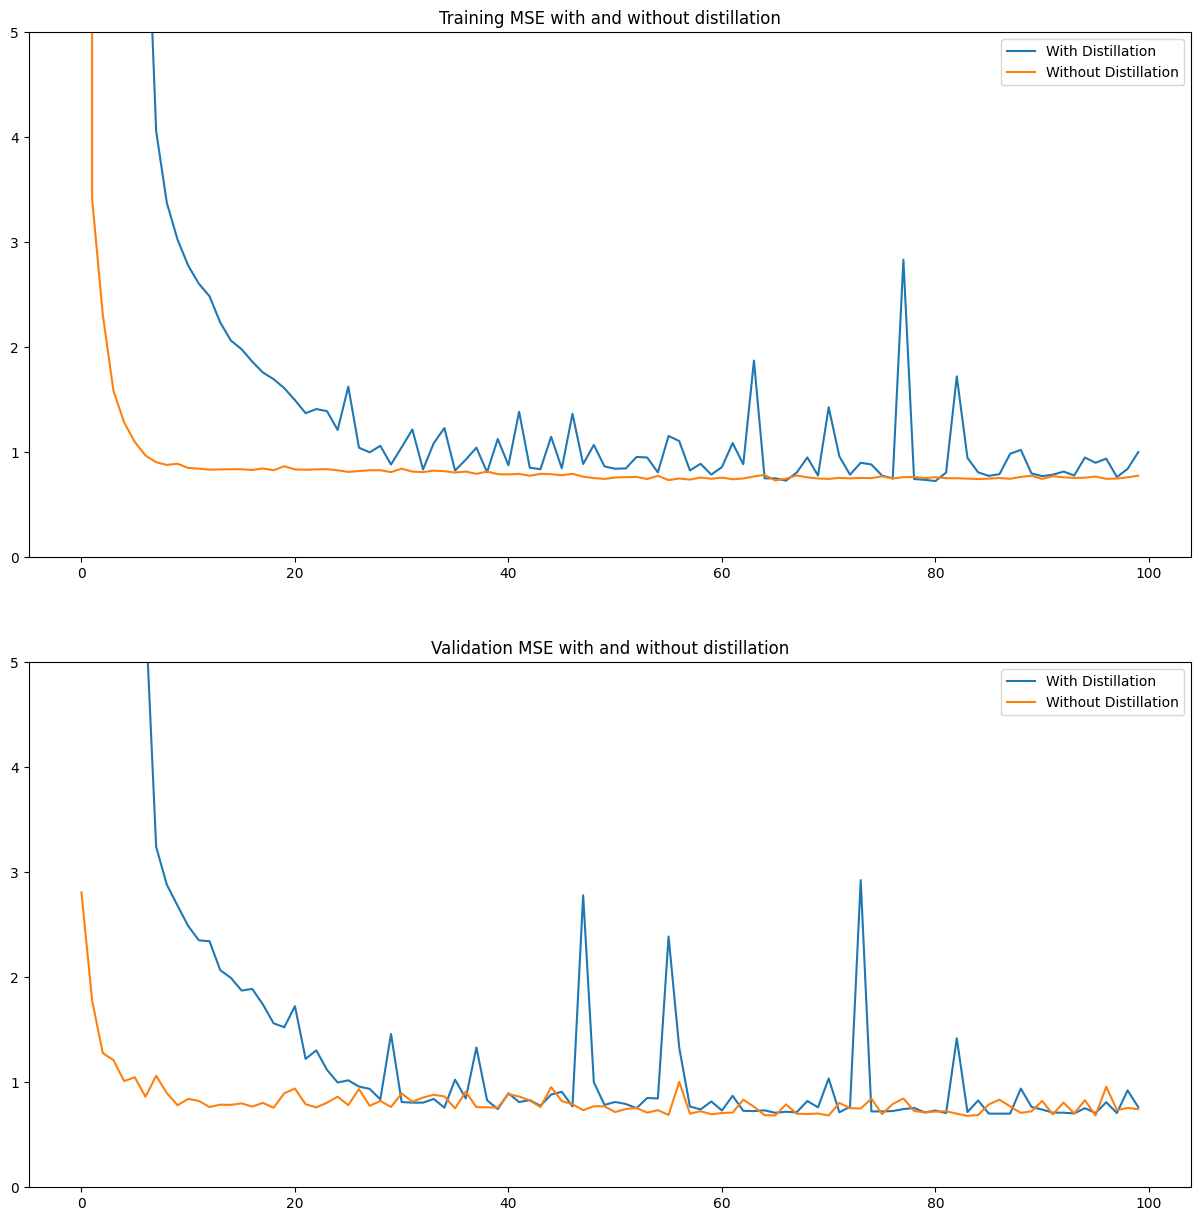

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.6169 +- 0.1593
Validation mse without disstillation 0.6461 +- 0.1318


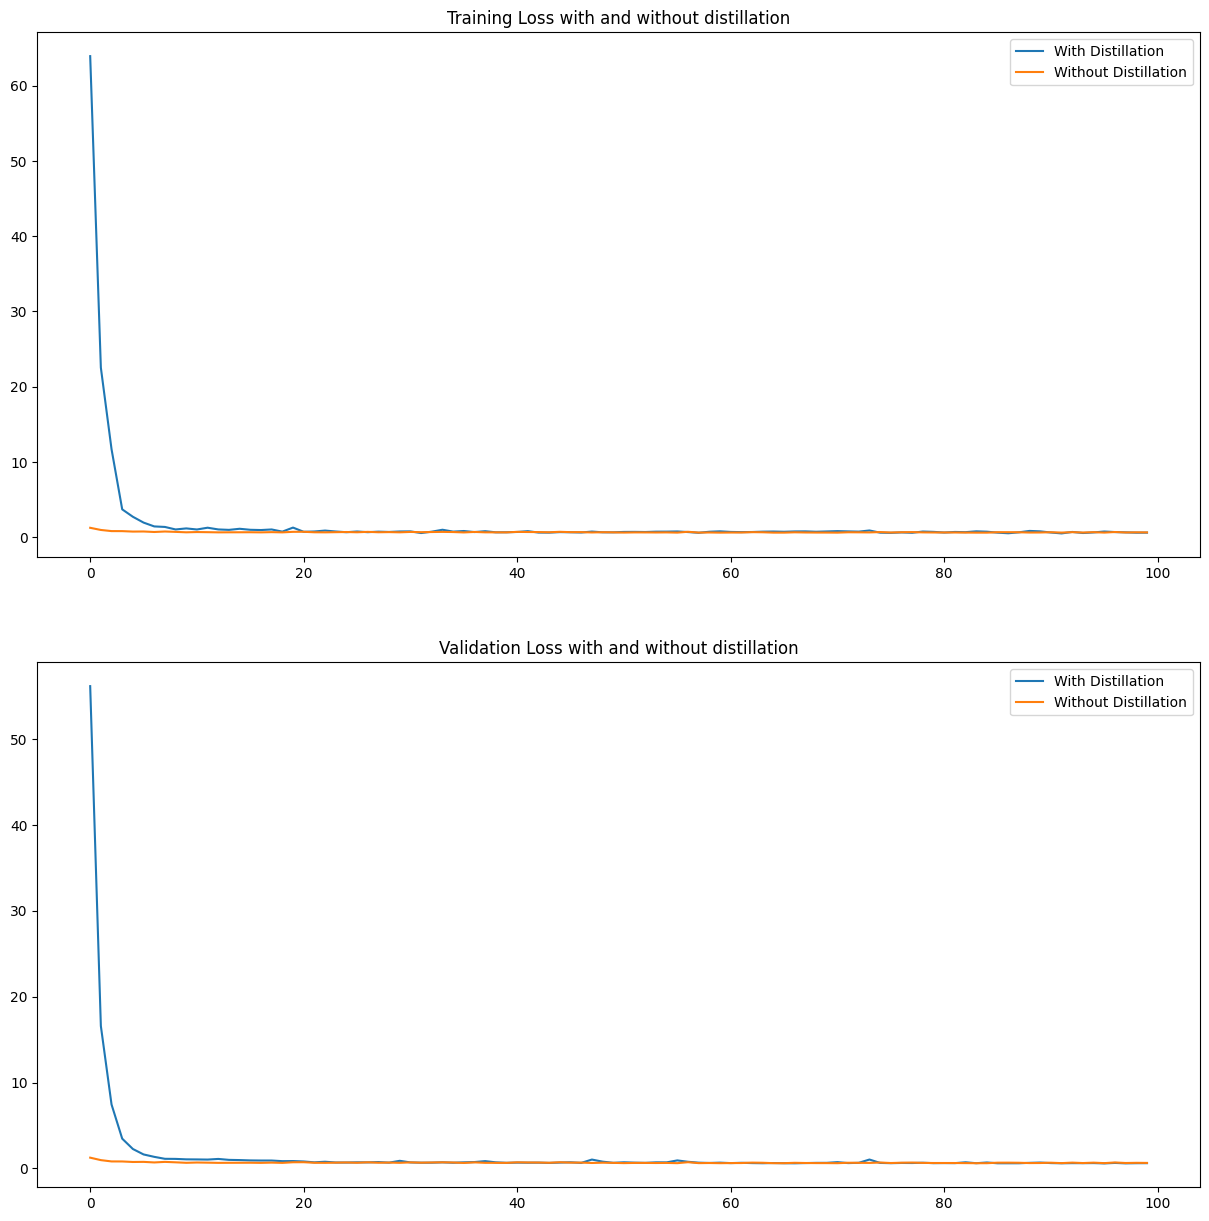

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [11]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 1s 2ms/step - mse: 217.1891 - mae: 3.9888 - mape: 281.1608 - student_loss: 3.9804 - distillation_loss: 215.8581
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 130.7752 - mae: 2.0556 - mape: 143.1166 - student_loss: 2.0509 - distillation_loss: 129.5215
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 106.7094 - mae: 1.6959 - mape: 117.6030 - student_loss: 1.7087 - distillation_loss: 105.6730
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 96.7438 - mae: 2.2675 - mape: 151.6356 - student_loss: 2.2621 - distillation_loss: 95.7104
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 75.7055 - mae: 1.6526 - mape: 114.2975 - student_loss: 1.6539 - distillation_loss: 74.7718
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 64.0772 - mae: 1.7327 - mape: 114.7695 - student_loss: 1.7292 - distillation_loss: 63.1336
Epoc

492/492 [==============================] - 1s 2ms/step - mse: 0.5681 - mae: 0.5715 - mape: 36.6862 - student_loss: 0.5722 - distillation_loss: 0.1553
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 5.6027 - mae: 1.0266 - mape: 66.3637 - student_loss: 1.0247 - distillation_loss: 5.1678
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5731 - mae: 0.5721 - mape: 36.9765 - student_loss: 0.5720 - distillation_loss: 0.1569
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5224 - mae: 0.5494 - mape: 35.4711 - student_loss: 0.5497 - distillation_loss: 0.1052
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 0.6292 - mae: 0.5913 - mape: 38.2785 - student_loss: 0.5915 - distillation_loss: 0.2089
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5871 - mae: 0.5792 - mape: 37.6097 - student_loss: 0.5789 - distillation_loss: 0.1721
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 35.8356 - mse: 18002.9121 - mae: 35.8356 - mape: 2332.1467
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 1.2436 - mse: 3.2783 - mae: 1.2436 - mape: 80.9592
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9369 - mse: 1.7739 - mae: 0.9369 - mape: 60.2520
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8251 - mse: 1.3244 - mae: 0.8251 - mape: 52.8425
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8941 - mse: 1.6210 - mae: 0.8941 - mape: 57.3595
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9969 - mse: 2.1940 - mae: 0.9969 - mape: 64.4835
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 1.0988 - mse: 2.7829 - mae: 1.0988 - mape: 71.4696
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 1.0343 - mse: 2.2721 - mae: 1.0343 - mape: 67.0

492/492 [==============================] - 1s 2ms/step - loss: 1.0140 - mse: 2.0569 - mae: 1.0140 - mape: 65.8022
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 1.0171 - mse: 2.2236 - mae: 1.0171 - mape: 66.2405
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9378 - mse: 1.7874 - mae: 0.9378 - mape: 60.2340
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8952 - mse: 1.7225 - mae: 0.8952 - mape: 57.4150
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8684 - mse: 1.5056 - mae: 0.8684 - mape: 55.6634
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9870 - mse: 2.2036 - mae: 0.9870 - mape: 63.3560
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 1.1844 - mse: 2.9389 - mae: 1.1844 - mape: 77.7938
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9879 - mse: 2.0107 - mae: 0.9879 - mape: 63.26

In [12]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 0.6400263905525208, 'mae': 0.5950599312782288, 'mape': 36.65724563598633, 'student_loss': 0.5987582802772522}
Test mse without disstillation {'loss': 0.622262179851532, 'mse': 0.6652295589447021, 'mae': 0.622262179851532, 'mape': 40.09638977050781}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
